In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from Models import *
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.datasets as dset
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import torch
import torch.optim as optim
from Models.gan_model import Generator, Discriminator
from training import Trainer
import os
import argparse
from torch.autograd import Variable

import numpy as np
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 50

print('using device:', device)

NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
# On training data we perform flips, crops etc
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./Datasets', train=True, download=True,
                             transform=transform_train)

loader_train = DataLoader(cifar10_train, batch_size=128, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./Datasets', train=True, download=True,
                           transform=transform_test)
loader_val = DataLoader(cifar10_val, batch_size=128, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./Datasets', train=False, download=True, 
                            transform=transform_test)

loader_test = DataLoader(cifar10_test, batch_size=64)



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.002)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

using device: cuda
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [45]:
md_spec=[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
learning_rate = 2e-3
model = cnn_net(md_spec)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [46]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    best_accur=0
    num_correct=0
    num_samples=0
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    accur_val,loss_val=check_accuracy(loader_val, model)
    val_loss.append(loss_val)
    val_accuracy.append(accur_val)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                accur_val,loss_val=check_accuracy(loader_val, model)
                if accur_val>best_accur:
                    best_accur=accur_val
                    best_model=model
                    save_checkpoint({'epoch': e + 1,
                                    'state_dict': model.state_dict(),
                                    'best_accuracy': best_accur}, True)
                print()
                acc = float(num_correct) / num_samples
                acc=acc*100
                num_correct=0
                num_samples=0
                train_loss.append(loss)
                val_loss.append(loss_val)
                train_accuracy.append(acc)
                val_accuracy.append(accur_val)
    return best_model,train_accuracy,val_accuracy,train_loss,val_loss

In [47]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    loss = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = loss + F.cross_entropy(scores, y)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc*100,loss


In [48]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [35]:
#best_model,train_accuracy,val_accuracy,train_loss,val_loss=train_model(model, optimizer, epochs=15)

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.title('Loss Plots')
plt.plot(train_loss,'o',label='Training loss')
plt.plot(val_loss,'o',label='Validation loss')
plt.xlabel('Iteration')
plt.legend(ncol=2, loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.savefig("cnn_loss.png")
plt.show

NameError: name 'train_loss' is not defined

<function matplotlib.pyplot.show(*args, **kw)>

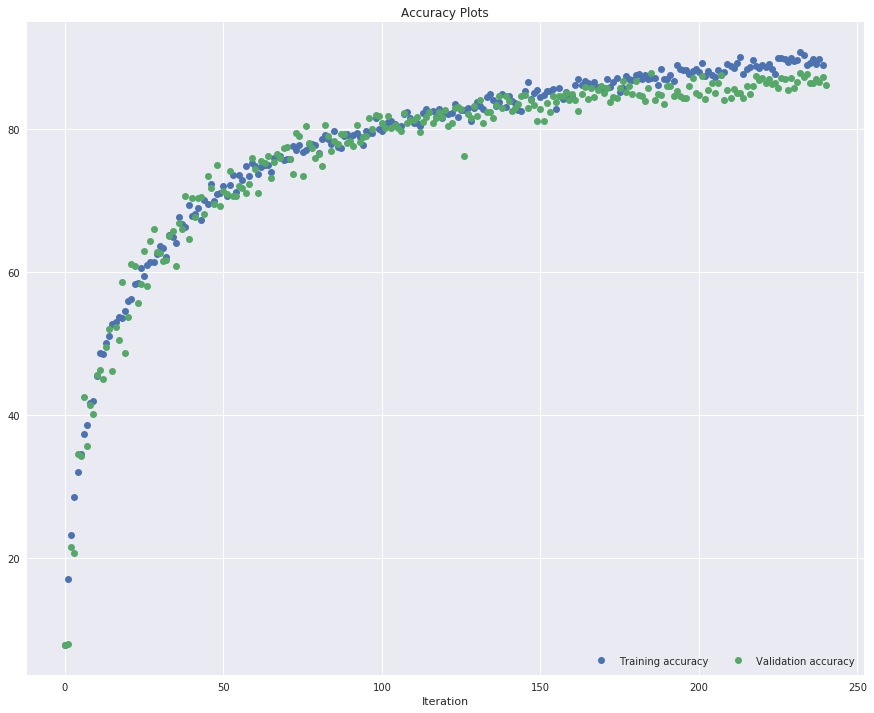

In [31]:
sns.set(style="darkgrid")
plt.title('Accuracy Plots')
plt.plot(train_accuracy,'o',label='Training accuracy')
plt.plot(val_accuracy,'o',label='Validation accuracy')
plt.xlabel('Iteration')
plt.legend(ncol=2, loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.savefig("cnn_accuracy.png")
plt.show

In [49]:
import pickle
save_checkpoint({'epoch': 15,'state_dict': best_model.state_dict()}, True)


# Saving the objects:
with open('cnn_hist.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([train_accuracy,val_accuracy,train_loss,val_loss], f)



NameError: name 'best_model' is not defined

In [ ]:
import pickle
checkpoint = torch.load('checkpoint.pth.tar')
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['state_dict'])
model.eval()
# Getting back the objects:
with open('cnn_hist.pkl','rb') as f:  # Python 3: open(..., 'rb')
    train_accuracy,val_accuracy,train_loss,val_loss = pickle.load(f)

In [ ]:
all_transforms = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])
# Get train and test data
train_data = dset.MNIST('./Datasets', train=True, download=True,
                            transform=all_transforms)
test_data = dset.MNIST('./Datasets', train=False,
                           transform=all_transforms)
# Create dataloaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

img_size = (32, 32, 3)

generator = Generator_c()
discriminator = Discriminator_c()

# Initialize optimizers
lr = 1e-4
betas = (.9, .99)
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# Train model
epochs = 600
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available())
G_loss,D_loss,GP_loss=trainer.train(loader_train, epochs, save_training_gif=True)


Epoch 1
Iteration 1
D loss: 93.25762176513672
GP: 93.26564025878906
Gradient norm: 0.03425893560051918


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration 51
D loss: 22.992740631103516
GP: 30.000804901123047
Gradient norm: 0.45337846875190735
G loss: -0.3751060962677002
Iteration 101
D loss: -52.12873840332031
GP: 9.242987632751465
Gradient norm: 1.2684121131896973
G loss: -3.482785940170288
Iteration 151
D loss: -70.83946990966797
GP: 11.469614028930664
Gradient norm: 1.30046546459198
G loss: -3.9776148796081543
Iteration 201
D loss: -77.4244613647461
GP: 11.754507064819336
Gradient norm: 1.3014732599258423
G loss: -4.277538299560547
Iteration 251
D loss: -78.86371612548828
GP: 11.715482711791992
Gradient norm: 1.3040128946304321
G loss: -4.3093695640563965
Iteration 301
D loss: -82.03868103027344
GP: 13.941326141357422
Gradient norm: 1.349661946296692
G loss: -4.093405723571777
Iteration 351
D loss: -83.04389190673828
GP: 13.600264549255371
Gradient norm: 1.3399714231491089
G loss: -3.742159605026245

Epoch 2
Iteration 1
D loss: -81.20692443847656
GP: 15.087495803833008
Gradient norm: 1.3685487508773804
G loss: -3.75547313690

Iteration 151
D loss: -65.1593246459961
GP: 9.863951683044434
Gradient norm: 1.3091100454330444
G loss: -15.0313081741333
Iteration 201
D loss: -65.1894760131836
GP: 8.582757949829102
Gradient norm: 1.283848524093628
G loss: -15.342292785644531
Iteration 251
D loss: -66.68062591552734
GP: 8.54896068572998
Gradient norm: 1.2871595621109009
G loss: -15.861376762390137
Iteration 301
D loss: -64.20196533203125
GP: 9.024335861206055
Gradient norm: 1.2928731441497803
G loss: -15.880017280578613
Iteration 351
D loss: -65.07984161376953
GP: 8.75902271270752
Gradient norm: 1.2897602319717407
G loss: -16.492124557495117

Epoch 10
Iteration 1
D loss: -59.97126770019531
GP: 7.970344543457031
Gradient norm: 1.2747958898544312
G loss: -16.55952262878418
Iteration 51
D loss: -67.02168273925781
GP: 7.251346111297607
Gradient norm: 1.2621158361434937
G loss: -16.75457000732422
Iteration 101
D loss: -64.18672943115234
GP: 8.084830284118652
Gradient norm: 1.2771070003509521
G loss: -16.802202224731445
It

Iteration 251
D loss: -53.653831481933594
GP: 6.495847702026367
Gradient norm: 1.238140344619751
G loss: -18.223907470703125
Iteration 301
D loss: -54.138214111328125
GP: 6.134767055511475
Gradient norm: 1.2375003099441528
G loss: -17.31282615661621
Iteration 351
D loss: -52.14564514160156
GP: 6.398934841156006
Gradient norm: 1.2389410734176636
G loss: -17.678499221801758

Epoch 18
Iteration 1
D loss: -52.708465576171875
GP: 5.821783542633057
Gradient norm: 1.2241278886795044
G loss: -16.807924270629883
Iteration 51
D loss: -52.71531295776367
GP: 6.056720733642578
Gradient norm: 1.2328661680221558
G loss: -18.0438289642334
Iteration 101
D loss: -51.19392776489258
GP: 6.7932820320129395
Gradient norm: 1.2476139068603516
G loss: -18.088966369628906
Iteration 151
D loss: -51.52122116088867
GP: 7.115900993347168
Gradient norm: 1.252652883529663
G loss: -17.49942970275879
Iteration 201
D loss: -51.130943298339844
GP: 5.453573226928711
Gradient norm: 1.2187005281448364
G loss: -16.8131999969

Iteration 351
D loss: -49.265445709228516
GP: 5.853763580322266
Gradient norm: 1.2113537788391113
G loss: -9.230545997619629

Epoch 26
Iteration 1
D loss: -50.99070739746094
GP: 6.747167587280273
Gradient norm: 1.2326064109802246
G loss: -8.44346809387207
Iteration 51
D loss: -50.12142562866211
GP: 5.638730525970459
Gradient norm: 1.207950472831726
G loss: -8.393192291259766
Iteration 101
D loss: -53.22245407104492
GP: 5.7524847984313965
Gradient norm: 1.2085716724395752
G loss: -8.538941383361816
Iteration 151
D loss: -52.30476760864258
GP: 6.216907024383545
Gradient norm: 1.2197751998901367
G loss: -7.737833499908447
Iteration 201
D loss: -50.82429122924805
GP: 6.28706693649292
Gradient norm: 1.2261178493499756
G loss: -8.06147289276123
Iteration 251
D loss: -51.1131706237793
GP: 7.510578155517578
Gradient norm: 1.2506517171859741
G loss: -9.247631072998047
Iteration 301
D loss: -50.78983688354492
GP: 6.52589750289917
Gradient norm: 1.2260773181915283
G loss: -8.562350273132324
Itera

Iteration 51
D loss: -50.161834716796875
GP: 7.443522930145264
Gradient norm: 1.2327446937561035
G loss: -3.6313669681549072
Iteration 101
D loss: -48.43117141723633
GP: 5.621676921844482
Gradient norm: 1.1896286010742188
G loss: -3.1239123344421387
Iteration 151
D loss: -49.111419677734375
GP: 6.495522975921631
Gradient norm: 1.2172901630401611
G loss: -2.4143874645233154
Iteration 201
D loss: -48.13676834106445
GP: 7.493610382080078
Gradient norm: 1.2419750690460205
G loss: -3.581394672393799
Iteration 251
D loss: -45.385990142822266
GP: 6.3755998611450195
Gradient norm: 1.204803705215454
G loss: -3.8510210514068604
Iteration 301
D loss: -50.46575927734375
GP: 6.633937835693359
Gradient norm: 1.2136561870574951
G loss: -3.6901049613952637
Iteration 351
D loss: -50.49848175048828
GP: 7.5594329833984375
Gradient norm: 1.2423789501190186
G loss: -4.550803184509277

Epoch 35
Iteration 1
D loss: -49.12940216064453
GP: 6.281339645385742
Gradient norm: 1.2061408758163452
G loss: -3.25555062

Iteration 151
D loss: -49.03812026977539
GP: 6.151785373687744
Gradient norm: 1.1913468837738037
G loss: -3.0007858276367188
Iteration 201
D loss: -46.15192413330078
GP: 5.178701877593994
Gradient norm: 1.1734763383865356
G loss: -2.9661455154418945
Iteration 251
D loss: -48.24150085449219
GP: 5.695127964019775
Gradient norm: 1.1849247217178345
G loss: -2.869607448577881
Iteration 301
D loss: -47.4129524230957
GP: 6.381707191467285
Gradient norm: 1.207217812538147
G loss: -2.7946293354034424
Iteration 351
D loss: -46.74357604980469
GP: 7.513549327850342
Gradient norm: 1.2311594486236572
G loss: -2.947530746459961

Epoch 43
Iteration 1
D loss: -46.82579803466797
GP: 6.595066070556641
Gradient norm: 1.1986504793167114
G loss: -3.349752187728882
Iteration 51
D loss: -46.752750396728516
GP: 8.429604530334473
Gradient norm: 1.2392823696136475
G loss: -3.5686960220336914
Iteration 101
D loss: -46.73316955566406
GP: 6.115142822265625
Gradient norm: 1.1879758834838867
G loss: -2.59176397323608

Iteration 251
D loss: -46.671958923339844
GP: 6.125843048095703
Gradient norm: 1.1843740940093994
G loss: 1.3375244140625
Iteration 301
D loss: -45.63658905029297
GP: 6.355721950531006
Gradient norm: 1.1932584047317505
G loss: 0.13314296305179596
Iteration 351
D loss: -45.37000274658203
GP: 6.973854064941406
Gradient norm: 1.2144701480865479
G loss: 1.034029483795166

Epoch 51
Iteration 1
D loss: -46.03118133544922
GP: 6.6280317306518555
Gradient norm: 1.1970701217651367
G loss: 0.27829480171203613
Iteration 51
D loss: -45.06937789916992
GP: 6.296200275421143
Gradient norm: 1.1985423564910889
G loss: 0.2568296194076538
Iteration 101
D loss: -44.9799919128418
GP: 5.968205451965332
Gradient norm: 1.1775383949279785
G loss: 0.5281473398208618
Iteration 151
D loss: -47.9413948059082
GP: 8.726578712463379
Gradient norm: 1.2421797513961792
G loss: 0.9652965664863586
Iteration 201
D loss: -45.64636993408203
GP: 6.7723236083984375
Gradient norm: 1.2108290195465088
G loss: -0.10795307159423828


Iteration 351
D loss: -48.144927978515625
GP: 6.011087417602539
Gradient norm: 1.1812325716018677
G loss: 3.246757745742798

Epoch 59
Iteration 1
D loss: -47.55533218383789
GP: 6.887477874755859
Gradient norm: 1.1930863857269287
G loss: 2.6882214546203613
Iteration 51
D loss: -45.74657440185547
GP: 6.549531936645508
Gradient norm: 1.1887043714523315
G loss: 1.83314847946167
Iteration 101
D loss: -47.52967834472656
GP: 7.30165958404541
Gradient norm: 1.2172439098358154
G loss: 2.4832093715667725
Iteration 151
D loss: -46.62558364868164
GP: 6.464645862579346
Gradient norm: 1.1950033903121948
G loss: 3.167288303375244
Iteration 201
D loss: -44.281795501708984
GP: 4.895506381988525
Gradient norm: 1.1581604480743408
G loss: 2.7430942058563232
Iteration 251
D loss: -47.74824142456055
GP: 7.697758674621582
Gradient norm: 1.22403085231781
G loss: 2.5881924629211426
Iteration 301
D loss: -48.249114990234375
GP: 6.407494068145752
Gradient norm: 1.2005691528320312
G loss: 3.0171921253204346
Itera

Iteration 51
D loss: -44.197021484375
GP: 7.561365127563477
Gradient norm: 1.2104806900024414
G loss: 3.365861415863037
Iteration 101
D loss: -47.13005828857422
GP: 9.344172477722168
Gradient norm: 1.2529011964797974
G loss: 3.895535707473755
Iteration 151
D loss: -45.86112594604492
GP: 6.471617221832275
Gradient norm: 1.1941090822219849
G loss: 4.396480560302734
Iteration 201
D loss: -47.159400939941406
GP: 7.486318588256836
Gradient norm: 1.216558814048767
G loss: 4.7996039390563965
Iteration 251
D loss: -44.231414794921875
GP: 5.9488420486450195
Gradient norm: 1.1617985963821411
G loss: 5.136054039001465
Iteration 301
D loss: -48.04821014404297
GP: 6.586202621459961
Gradient norm: 1.186863899230957
G loss: 4.851585865020752
Iteration 351
D loss: -46.83155059814453
GP: 8.681811332702637
Gradient norm: 1.2437736988067627
G loss: 5.123680114746094

Epoch 68
Iteration 1
D loss: -45.879981994628906
GP: 7.145645618438721
Gradient norm: 1.1828975677490234
G loss: 5.247659206390381
Iteratio

Iteration 201
D loss: -47.936927795410156
GP: 7.297834873199463
Gradient norm: 1.2126613855361938
G loss: 6.851300239562988
Iteration 251
D loss: -46.96739196777344
GP: 6.917398452758789
Gradient norm: 1.1967356204986572
G loss: 8.157224655151367
Iteration 301
D loss: -44.510467529296875
GP: 6.747026443481445
Gradient norm: 1.1883633136749268
G loss: 8.086764335632324
Iteration 351
D loss: -46.43756103515625
GP: 6.9767608642578125
Gradient norm: 1.1932075023651123
G loss: 7.245584964752197

Epoch 76
Iteration 1
D loss: -45.38705062866211
GP: 8.404267311096191
Gradient norm: 1.2167800664901733
G loss: 7.145129680633545
Iteration 51
D loss: -43.9930419921875
GP: 6.710768699645996
Gradient norm: 1.1856746673583984
G loss: 6.96753454208374
Iteration 101
D loss: -45.18671798706055
GP: 5.3817291259765625
Gradient norm: 1.1642223596572876
G loss: 7.205475807189941
Iteration 151
D loss: -45.31471252441406
GP: 6.133709907531738
Gradient norm: 1.1899869441986084
G loss: 9.955531120300293
Iterati

Iteration 351
D loss: -45.498653411865234
GP: 4.96498966217041
Gradient norm: 1.1608198881149292
G loss: 10.543366432189941

Epoch 84
Iteration 1
D loss: -44.61565399169922
GP: 8.53077507019043
Gradient norm: 1.2232370376586914
G loss: 10.269874572753906
Iteration 51
D loss: -45.26087188720703
GP: 8.43883228302002
Gradient norm: 1.2213486433029175
G loss: 10.496065139770508
Iteration 101
D loss: -46.58463668823242
GP: 5.883950233459473
Gradient norm: 1.1811636686325073
G loss: 10.234750747680664
Iteration 151
D loss: -45.646705627441406
GP: 6.35365104675293
Gradient norm: 1.1843671798706055
G loss: 9.330766677856445
Iteration 201
D loss: -43.7445068359375
GP: 6.228899002075195
Gradient norm: 1.1782581806182861
G loss: 9.254018783569336
Iteration 251
D loss: -45.19313430786133
GP: 6.0490312576293945
Gradient norm: 1.1742606163024902
G loss: 9.365147590637207
Iteration 301
D loss: -45.87175750732422
GP: 7.033581256866455
Gradient norm: 1.2038490772247314
G loss: 9.583724021911621
Iterati

Iteration 51
D loss: -46.555843353271484
GP: 7.206559658050537
Gradient norm: 1.2008787393569946
G loss: 9.609491348266602
Iteration 101
D loss: -45.684722900390625
GP: 7.326320648193359
Gradient norm: 1.2047631740570068
G loss: 8.66071605682373
Iteration 151
D loss: -46.5526237487793
GP: 7.371777534484863
Gradient norm: 1.1993918418884277
G loss: 10.014782905578613
Iteration 201
D loss: -44.93294143676758
GP: 6.869602680206299
Gradient norm: 1.1895967721939087
G loss: 10.744987487792969
Iteration 251
D loss: -46.51668167114258
GP: 5.945766448974609
Gradient norm: 1.1647393703460693
G loss: 9.834447860717773
Iteration 301
D loss: -46.68667221069336
GP: 6.562548637390137
Gradient norm: 1.177834153175354
G loss: 8.856273651123047
Iteration 351
D loss: -45.331077575683594
GP: 7.883969306945801
Gradient norm: 1.2034409046173096
G loss: 7.777762413024902

Epoch 93
Iteration 1
D loss: -41.79301071166992
GP: 7.75674295425415
Gradient norm: 1.2065577507019043
G loss: 8.98299503326416
Iteration

Iteration 201
D loss: -46.504295349121094
GP: 7.563918113708496
Gradient norm: 1.2140663862228394
G loss: 9.776175498962402
Iteration 251
D loss: -46.510047912597656
GP: 7.430845260620117
Gradient norm: 1.1979830265045166
G loss: 10.059003829956055
Iteration 301
D loss: -45.41716766357422
GP: 7.241462707519531
Gradient norm: 1.1807852983474731
G loss: 9.067401885986328
Iteration 351
D loss: -45.758304595947266
GP: 7.45175838470459
Gradient norm: 1.208736777305603
G loss: 7.553319454193115

Epoch 101
Iteration 1
D loss: -45.685081481933594
GP: 7.723259925842285
Gradient norm: 1.199373483657837
G loss: 8.210722923278809
Iteration 51
D loss: -45.36469268798828
GP: 5.979841232299805
Gradient norm: 1.1815402507781982
G loss: 9.201471328735352
Iteration 101
D loss: -45.348350524902344
GP: 8.78470516204834
Gradient norm: 1.2244235277175903
G loss: 9.742027282714844
Iteration 151
D loss: -44.392738342285156
GP: 7.682276725769043
Gradient norm: 1.1961874961853027
G loss: 10.433331489562988
Iter

Iteration 351
D loss: -44.746673583984375
GP: 7.268763065338135
Gradient norm: 1.2005029916763306
G loss: 9.635912895202637

Epoch 109
Iteration 1
D loss: -45.69835662841797
GP: 6.686895370483398
Gradient norm: 1.1862571239471436
G loss: 10.351316452026367
Iteration 51
D loss: -44.310028076171875
GP: 6.979966640472412
Gradient norm: 1.167422890663147
G loss: 8.918109893798828
Iteration 101
D loss: -46.76129913330078
GP: 7.188240051269531
Gradient norm: 1.1942434310913086
G loss: 10.53144645690918
Iteration 151
D loss: -43.25886917114258
GP: 6.227840900421143
Gradient norm: 1.177178144454956
G loss: 9.303386688232422
Iteration 201
D loss: -45.15656280517578
GP: 5.08408784866333
Gradient norm: 1.167891263961792
G loss: 10.318650245666504
Iteration 251
D loss: -43.16193389892578
GP: 8.095462799072266
Gradient norm: 1.2095528841018677
G loss: 10.56124496459961
Iteration 301
D loss: -44.26552963256836
GP: 6.455214023590088
Gradient norm: 1.1891968250274658
G loss: 9.858526229858398
Iteratio

Iteration 51
D loss: -44.796485900878906
GP: 6.692670822143555
Gradient norm: 1.1913654804229736
G loss: 15.703472137451172
Iteration 101
D loss: -42.771724700927734
GP: 7.469284534454346
Gradient norm: 1.1837302446365356
G loss: 15.30087947845459
Iteration 151
D loss: -45.398826599121094
GP: 6.739487648010254
Gradient norm: 1.1902005672454834
G loss: 12.654278755187988
Iteration 201
D loss: -43.5601921081543
GP: 7.48258113861084
Gradient norm: 1.1947473287582397
G loss: 13.993301391601562
Iteration 251
D loss: -43.683719635009766
GP: 5.397091865539551
Gradient norm: 1.1524208784103394
G loss: 14.341686248779297
Iteration 301
D loss: -43.685829162597656
GP: 6.638650894165039
Gradient norm: 1.1881599426269531
G loss: 15.994348526000977
Iteration 351
D loss: -44.098785400390625
GP: 5.342956066131592
Gradient norm: 1.1611653566360474
G loss: 15.32783031463623

Epoch 118
Iteration 1
D loss: -44.28699493408203
GP: 7.386373519897461
Gradient norm: 1.2087732553482056
G loss: 15.319580078125
I

Iteration 151
D loss: -44.060184478759766
GP: 5.751197338104248
Gradient norm: 1.1562994718551636
G loss: 13.906384468078613
Iteration 201
D loss: -44.27886962890625
GP: 7.46833610534668
Gradient norm: 1.2096830606460571
G loss: 14.028465270996094
Iteration 251
D loss: -42.1854362487793
GP: 6.876728057861328
Gradient norm: 1.1835204362869263
G loss: 13.870996475219727
Iteration 301
D loss: -44.162620544433594
GP: 7.232251167297363
Gradient norm: 1.1847130060195923
G loss: 12.106827735900879
Iteration 351
D loss: -42.846893310546875
GP: 4.702751159667969
Gradient norm: 1.1479805707931519
G loss: 12.252951622009277

Epoch 126
Iteration 1
D loss: -44.084407806396484
GP: 7.551555633544922
Gradient norm: 1.1885199546813965
G loss: 12.614680290222168
Iteration 51
D loss: -45.30681228637695
GP: 7.499185085296631
Gradient norm: 1.209152102470398
G loss: 14.237648963928223
Iteration 101
D loss: -43.86582565307617
GP: 8.14165210723877
Gradient norm: 1.2052409648895264
G loss: 14.330562591552734


Iteration 251
D loss: -42.586429595947266
GP: 6.824198246002197
Gradient norm: 1.1825255155563354
G loss: 13.105388641357422
Iteration 301
D loss: -42.154117584228516
GP: 5.7118940353393555
Gradient norm: 1.1572356224060059
G loss: 11.698134422302246
Iteration 351
D loss: -43.40816879272461
GP: 5.986575126647949
Gradient norm: 1.164681077003479
G loss: 11.768999099731445

Epoch 134
Iteration 1
D loss: -40.58103561401367
GP: 5.348635196685791
Gradient norm: 1.1485528945922852
G loss: 13.729216575622559
Iteration 51
D loss: -42.355003356933594
GP: 6.923911094665527
Gradient norm: 1.182230830192566
G loss: 12.172435760498047
Iteration 101
D loss: -43.97642517089844
GP: 7.550546646118164
Gradient norm: 1.1913986206054688
G loss: 12.005532264709473
Iteration 151
D loss: -44.16096115112305
GP: 6.4320969581604
Gradient norm: 1.162250280380249
G loss: 12.875521659851074
Iteration 201
D loss: -42.640289306640625
GP: 6.454530715942383
Gradient norm: 1.1847108602523804
G loss: 13.406373977661133


Iteration 351
D loss: -43.896141052246094
GP: 6.768002510070801
Gradient norm: 1.1835358142852783
G loss: 13.512419700622559

Epoch 142
Iteration 1
D loss: -44.2362174987793
GP: 8.494396209716797
Gradient norm: 1.2079439163208008
G loss: 13.066059112548828
Iteration 51
D loss: -44.19919204711914
GP: 6.889443874359131
Gradient norm: 1.179559588432312
G loss: 13.378074645996094
Iteration 101
D loss: -43.676063537597656
GP: 7.751102447509766
Gradient norm: 1.1998038291931152
G loss: 12.801794052124023
Iteration 151
D loss: -43.301631927490234
GP: 5.712279796600342
Gradient norm: 1.1631063222885132
G loss: 12.945999145507812
Iteration 201
D loss: -42.18597412109375
GP: 5.557661056518555
Gradient norm: 1.1652772426605225
G loss: 13.356422424316406
Iteration 251
D loss: -40.792057037353516
GP: 6.481245994567871
Gradient norm: 1.1752511262893677
G loss: 12.766314506530762
Iteration 301
D loss: -42.091796875
GP: 5.338927268981934
Gradient norm: 1.154735803604126
G loss: 13.741214752197266
Iter

Iteration 51
D loss: -43.726871490478516
GP: 7.570952892303467
Gradient norm: 1.2010254859924316
G loss: 10.971199989318848
Iteration 101
D loss: -43.88225555419922
GP: 8.373825073242188
Gradient norm: 1.1911568641662598
G loss: 12.142539024353027
Iteration 151
D loss: -42.71653366088867
GP: 6.54921293258667
Gradient norm: 1.1758754253387451
G loss: 11.09337043762207
Iteration 201
D loss: -43.066402435302734
GP: 5.936441898345947
Gradient norm: 1.1727434396743774
G loss: 11.523509979248047
Iteration 251
D loss: -43.510135650634766
GP: 7.254218578338623
Gradient norm: 1.2111883163452148
G loss: 12.209293365478516
Iteration 301
D loss: -44.827239990234375
GP: 5.485247611999512
Gradient norm: 1.1628113985061646
G loss: 11.038372039794922
Iteration 351
D loss: -42.290122985839844
GP: 7.064105033874512
Gradient norm: 1.1892415285110474
G loss: 11.627623558044434

Epoch 151
Iteration 1
D loss: -43.069732666015625
GP: 5.470117568969727
Gradient norm: 1.150686264038086
G loss: 12.8238277435302

Iteration 151
D loss: -42.63785171508789
GP: 8.09878158569336
Gradient norm: 1.210257649421692
G loss: 11.161617279052734
Iteration 201
D loss: -42.299991607666016
GP: 7.204960823059082
Gradient norm: 1.1898033618927002
G loss: 9.598123550415039
Iteration 251
D loss: -45.08039093017578
GP: 7.68824577331543
Gradient norm: 1.195513129234314
G loss: 10.27978229522705
Iteration 301
D loss: -42.5727424621582
GP: 6.289832592010498
Gradient norm: 1.165084719657898
G loss: 10.123855590820312
Iteration 351
D loss: -43.38259506225586
GP: 6.275649070739746
Gradient norm: 1.1689437627792358
G loss: 11.030874252319336

Epoch 159
Iteration 1
D loss: -40.35023880004883
GP: 6.906464099884033
Gradient norm: 1.1712098121643066
G loss: 11.260481834411621
Iteration 51
D loss: -43.959022521972656
GP: 7.1953511238098145
Gradient norm: 1.1942845582962036
G loss: 10.328581809997559
Iteration 101
D loss: -41.253902435302734
GP: 7.397767066955566
Gradient norm: 1.1933989524841309
G loss: 11.387974739074707
Iter

Iteration 251
D loss: -44.19392776489258
GP: 7.515331268310547
Gradient norm: 1.1724504232406616
G loss: 9.216492652893066
Iteration 301
D loss: -43.54234313964844
GP: 5.936005115509033
Gradient norm: 1.1662517786026
G loss: 11.231467247009277
Iteration 351
D loss: -41.90782928466797
GP: 7.6199951171875
Gradient norm: 1.2018903493881226
G loss: 10.891697883605957

Epoch 167
Iteration 1
D loss: -42.05669403076172
GP: 5.523595809936523
Gradient norm: 1.1580922603607178
G loss: 10.258955001831055
Iteration 51
D loss: -47.30026626586914
GP: 7.151599884033203
Gradient norm: 1.1798527240753174
G loss: 11.198417663574219
Iteration 101
D loss: -43.51435852050781
GP: 6.869340419769287
Gradient norm: 1.1791632175445557
G loss: 9.889423370361328
Iteration 151
D loss: -42.98408889770508
GP: 8.028095245361328
Gradient norm: 1.2079143524169922
G loss: 9.123421669006348
Iteration 201
D loss: -43.68748092651367
GP: 6.799106597900391
Gradient norm: 1.1620683670043945
G loss: 8.999800682067871
Iteration


Epoch 175
Iteration 1
D loss: -42.52950668334961
GP: 7.346904754638672
Gradient norm: 1.204232096672058
G loss: 8.766777038574219
Iteration 51
D loss: -44.32416915893555
GP: 5.812816143035889
Gradient norm: 1.162803053855896
G loss: 9.578554153442383
Iteration 101
D loss: -43.662296295166016
GP: 5.802325248718262
Gradient norm: 1.1646405458450317
G loss: 6.983448028564453
Iteration 151
D loss: -43.28953552246094
GP: 6.195048809051514
Gradient norm: 1.152497410774231
G loss: 8.461283683776855
Iteration 201
D loss: -44.07952880859375
GP: 7.210288047790527
Gradient norm: 1.199709415435791
G loss: 7.858500957489014
Iteration 251
D loss: -43.01838684082031
GP: 7.256510257720947
Gradient norm: 1.1912617683410645
G loss: 9.31982707977295
Iteration 301
D loss: -46.29134750366211
GP: 7.170962333679199
Gradient norm: 1.198848843574524
G loss: 6.672261714935303
Iteration 351
D loss: -42.34696960449219
GP: 6.548547744750977
Gradient norm: 1.1854748725891113
G loss: 8.628813743591309

Epoch 176
It

Iteration 151
D loss: -41.820377349853516
GP: 6.544631004333496
Gradient norm: 1.1636431217193604
G loss: 7.585343837738037
Iteration 201
D loss: -42.203102111816406
GP: 5.880734920501709
Gradient norm: 1.1733942031860352
G loss: 8.663506507873535
Iteration 251
D loss: -43.64924621582031
GP: 8.055233001708984
Gradient norm: 1.1841551065444946
G loss: 6.927913665771484
Iteration 301
D loss: -40.18443298339844
GP: 8.152483940124512
Gradient norm: 1.199450969696045
G loss: 7.07976770401001
Iteration 351
D loss: -42.888187408447266
GP: 7.546398639678955
Gradient norm: 1.195517897605896
G loss: 8.345917701721191

Epoch 184
Iteration 1
D loss: -43.198177337646484
GP: 9.079607963562012
Gradient norm: 1.2355806827545166
G loss: 7.826138496398926
Iteration 51
D loss: -43.815189361572266
GP: 6.912151336669922
Gradient norm: 1.1730526685714722
G loss: 7.1402058601379395
Iteration 101
D loss: -42.09947967529297
GP: 6.154240608215332
Gradient norm: 1.1780864000320435
G loss: 7.848694324493408
Itera

Iteration 301
D loss: -44.788116455078125
GP: 6.108865737915039
Gradient norm: 1.1669994592666626
G loss: 8.552721977233887
Iteration 351
D loss: -41.09691619873047
GP: 8.175530433654785
Gradient norm: 1.203412652015686
G loss: 9.76253604888916

Epoch 192
Iteration 1
D loss: -43.577491760253906
GP: 9.391457557678223
Gradient norm: 1.2188140153884888
G loss: 10.196751594543457
Iteration 51
D loss: -41.57230758666992
GP: 6.821496486663818
Gradient norm: 1.182371973991394
G loss: 9.715232849121094
Iteration 101
D loss: -43.896392822265625
GP: 7.359326362609863
Gradient norm: 1.169978141784668
G loss: 8.87881851196289
Iteration 151
D loss: -41.3979377746582
GP: 5.810047149658203
Gradient norm: 1.1655176877975464
G loss: 9.944228172302246
Iteration 201
D loss: -42.21847915649414
GP: 8.580432891845703
Gradient norm: 1.2187044620513916
G loss: 9.50688362121582
Iteration 251
D loss: -41.95868682861328
GP: 6.024553298950195
Gradient norm: 1.168769121170044
G loss: 8.150641441345215
Iteration 30

Iteration 51
D loss: -41.405338287353516
GP: 5.475895881652832
Gradient norm: 1.1509943008422852
G loss: 6.005695819854736
Iteration 101
D loss: -45.147621154785156
GP: 6.041831970214844
Gradient norm: 1.1706360578536987
G loss: 5.422173500061035
Iteration 151
D loss: -44.472740173339844
GP: 6.397027015686035
Gradient norm: 1.1636440753936768
G loss: 7.280004024505615
Iteration 201
D loss: -43.698570251464844
GP: 7.429328441619873
Gradient norm: 1.1973910331726074
G loss: 6.554208278656006
Iteration 251
D loss: -42.116947174072266
GP: 6.426486968994141
Gradient norm: 1.1756590604782104
G loss: 8.071210861206055
Iteration 301
D loss: -42.62211608886719
GP: 6.049298286437988
Gradient norm: 1.1547092199325562
G loss: 6.577395915985107
Iteration 351
D loss: -44.50833511352539
GP: 7.447003364562988
Gradient norm: 1.1877702474594116
G loss: 7.422663688659668

Epoch 201
Iteration 1
D loss: -42.456268310546875
GP: 6.98470401763916
Gradient norm: 1.201156735420227
G loss: 6.8801493644714355
Ite

Iteration 201
D loss: -41.96782302856445
GP: 6.792423725128174
Gradient norm: 1.1671630144119263
G loss: 8.303511619567871
Iteration 251
D loss: -44.2451286315918
GP: 8.761124610900879
Gradient norm: 1.2110406160354614
G loss: 7.662006378173828
Iteration 301
D loss: -45.87705993652344
GP: 7.502382278442383
Gradient norm: 1.2067968845367432
G loss: 9.973821640014648
Iteration 351
D loss: -43.243690490722656
GP: 8.782709121704102
Gradient norm: 1.2066984176635742
G loss: 8.186301231384277

Epoch 209
Iteration 1
D loss: -44.4549560546875
GP: 8.007179260253906
Gradient norm: 1.1999348402023315
G loss: 9.531476974487305
Iteration 51
D loss: -41.402587890625
GP: 7.606149196624756
Gradient norm: 1.192205786705017
G loss: 9.213457107543945
Iteration 101
D loss: -43.5142822265625
GP: 8.0061674118042
Gradient norm: 1.2124791145324707
G loss: 9.282898902893066
Iteration 151
D loss: -45.9129753112793
GP: 8.304463386535645
Gradient norm: 1.2083046436309814
G loss: 9.48948860168457
Iteration 201
D l

Iteration 351
D loss: -42.95974349975586
GP: 7.70949125289917
Gradient norm: 1.198928713798523
G loss: 10.157026290893555

Epoch 217
Iteration 1
D loss: -44.29401779174805
GP: 7.634294033050537
Gradient norm: 1.1905995607376099
G loss: 10.51445198059082
Iteration 51
D loss: -43.25041580200195
GP: 7.093600273132324
Gradient norm: 1.1756659746170044
G loss: 9.628973960876465
Iteration 101
D loss: -43.178192138671875
GP: 5.654748916625977
Gradient norm: 1.1613543033599854
G loss: 9.38713264465332
Iteration 151
D loss: -40.32961654663086
GP: 5.483826637268066
Gradient norm: 1.1577849388122559
G loss: 9.182796478271484
Iteration 201
D loss: -43.123653411865234
GP: 6.576610088348389
Gradient norm: 1.1692641973495483
G loss: 8.229747772216797
Iteration 251
D loss: -42.335689544677734
GP: 7.959380149841309
Gradient norm: 1.195358395576477
G loss: 9.643720626831055
Iteration 301
D loss: -41.66983413696289
GP: 7.127560615539551
Gradient norm: 1.166658878326416
G loss: 9.658371925354004
Iteration

Iteration 51
D loss: -44.308475494384766
GP: 6.007697582244873
Gradient norm: 1.1661113500595093
G loss: 13.7423677444458
Iteration 101
D loss: -42.56300354003906
GP: 7.38123893737793
Gradient norm: 1.1943824291229248
G loss: 13.502446174621582
Iteration 151
D loss: -43.368621826171875
GP: 7.0536041259765625
Gradient norm: 1.1955336332321167
G loss: 15.036275863647461
Iteration 201
D loss: -41.993614196777344
GP: 7.624921798706055
Gradient norm: 1.194485068321228
G loss: 15.957395553588867
Iteration 251
D loss: -40.497623443603516
GP: 8.184796333312988
Gradient norm: 1.2053877115249634
G loss: 13.892626762390137
Iteration 301
D loss: -46.958824157714844
GP: 8.843729019165039
Gradient norm: 1.207430362701416
G loss: 15.186522483825684
Iteration 351
D loss: -43.90560531616211
GP: 5.686878681182861
Gradient norm: 1.1582374572753906
G loss: 13.61732292175293

Epoch 226
Iteration 1
D loss: -43.95624923706055
GP: 6.612495422363281
Gradient norm: 1.17372465133667
G loss: 14.922232627868652
It

Iteration 151
D loss: -45.38871765136719
GP: 7.101119041442871
Gradient norm: 1.172286033630371
G loss: 17.02842140197754
Iteration 201
D loss: -42.13370895385742
GP: 8.365440368652344
Gradient norm: 1.2079668045043945
G loss: 16.27903938293457
Iteration 251
D loss: -41.704833984375
GP: 6.697641372680664
Gradient norm: 1.1791014671325684
G loss: 16.959413528442383
Iteration 301
D loss: -44.76179504394531
GP: 7.453985214233398
Gradient norm: 1.1825306415557861
G loss: 15.891281127929688
Iteration 351
D loss: -41.2087287902832
GP: 7.528307914733887
Gradient norm: 1.1977031230926514
G loss: 15.623983383178711

Epoch 234
Iteration 1
D loss: -42.698753356933594
GP: 7.1524248123168945
Gradient norm: 1.1911706924438477
G loss: 15.454798698425293
Iteration 51
D loss: -44.75806427001953
GP: 8.625853538513184
Gradient norm: 1.210484266281128
G loss: 15.407957077026367
Iteration 101
D loss: -42.98583221435547
GP: 6.462440013885498
Gradient norm: 1.172582983970642
G loss: 16.427574157714844
Iterat

Iteration 251
D loss: -44.07500457763672
GP: 8.732133865356445
Gradient norm: 1.2247768640518188
G loss: 19.480722427368164
Iteration 301
D loss: -43.074649810791016
GP: 8.68421459197998
Gradient norm: 1.2058902978897095
G loss: 19.709184646606445
Iteration 351
D loss: -43.47887420654297
GP: 6.66197395324707
Gradient norm: 1.1551623344421387
G loss: 18.666399002075195

Epoch 242
Iteration 1
D loss: -44.12901306152344
GP: 7.485454559326172
Gradient norm: 1.1912164688110352
G loss: 18.78009033203125
Iteration 51
D loss: -41.90117263793945
GP: 7.133002281188965
Gradient norm: 1.1883491277694702
G loss: 19.753402709960938
Iteration 101
D loss: -40.81857681274414
GP: 5.865854740142822
Gradient norm: 1.1659226417541504
G loss: 19.10013198852539
Iteration 151
D loss: -42.795928955078125
GP: 5.566214561462402
Gradient norm: 1.1613130569458008
G loss: 18.67487907409668
Iteration 201
D loss: -45.781002044677734
GP: 6.347899913787842
Gradient norm: 1.1630611419677734
G loss: 20.85354232788086
Ite

Iteration 351
D loss: -43.46055221557617
GP: 7.189422130584717
Gradient norm: 1.1971282958984375
G loss: 14.50506591796875

Epoch 250
Iteration 1
D loss: -42.956703186035156
GP: 7.85389518737793
Gradient norm: 1.212633728981018
G loss: 14.839545249938965
Iteration 51
D loss: -41.49771499633789
GP: 8.130507469177246
Gradient norm: 1.1986383199691772
G loss: 13.31749439239502
Iteration 101
D loss: -42.450416564941406
GP: 7.819027900695801
Gradient norm: 1.1867088079452515
G loss: 16.166255950927734
Iteration 151
D loss: -41.200008392333984
GP: 9.349284172058105
Gradient norm: 1.2222082614898682
G loss: 16.518821716308594
Iteration 201
D loss: -43.46018981933594
GP: 7.102601528167725
Gradient norm: 1.183043360710144
G loss: 15.408738136291504
Iteration 251
D loss: -40.696128845214844
GP: 8.743446350097656
Gradient norm: 1.2221602201461792
G loss: 16.198471069335938
Iteration 301
D loss: -42.56390380859375
GP: 8.09668254852295
Gradient norm: 1.2086881399154663
G loss: 16.387699127197266
It

Iteration 51
D loss: -43.93780517578125
GP: 5.838376998901367
Gradient norm: 1.165832757949829
G loss: 15.540416717529297
Iteration 101
D loss: -41.30647659301758
GP: 6.976503849029541
Gradient norm: 1.1700738668441772
G loss: 15.592695236206055
Iteration 151
D loss: -43.99894714355469
GP: 8.010452270507812
Gradient norm: 1.199060082435608
G loss: 15.587430000305176
Iteration 201
D loss: -42.892730712890625
GP: 8.920778274536133
Gradient norm: 1.20290207862854
G loss: 16.22313117980957
Iteration 251
D loss: -38.898963928222656
GP: 5.947751998901367
Gradient norm: 1.1373014450073242
G loss: 14.842801094055176
Iteration 301
D loss: -44.03556823730469
GP: 9.16130256652832
Gradient norm: 1.2101943492889404
G loss: 15.772318840026855
Iteration 351
D loss: -44.892578125
GP: 6.928205490112305
Gradient norm: 1.169744610786438
G loss: 16.060012817382812

Epoch 259
Iteration 1
D loss: -41.66293716430664
GP: 5.961245536804199
Gradient norm: 1.1467365026474
G loss: 15.15403938293457
Iteration 51
D

Iteration 151
D loss: -41.703575134277344
GP: 7.465539932250977
Gradient norm: 1.1936274766921997
G loss: 14.735599517822266
Iteration 201
D loss: -43.5181884765625
GP: 7.71910285949707
Gradient norm: 1.202045202255249
G loss: 15.989188194274902
Iteration 251
D loss: -44.11810302734375
GP: 7.364922046661377
Gradient norm: 1.1744009256362915
G loss: 14.647343635559082
Iteration 301
D loss: -44.31535720825195
GP: 6.2062764167785645
Gradient norm: 1.1684383153915405
G loss: 16.420452117919922
Iteration 351
D loss: -42.98955535888672
GP: 5.9986186027526855
Gradient norm: 1.1623032093048096
G loss: 13.939338684082031

Epoch 267
Iteration 1
D loss: -41.69371795654297
GP: 7.662290573120117
Gradient norm: 1.1802194118499756
G loss: 14.207530975341797
Iteration 51
D loss: -42.192806243896484
GP: 8.433792114257812
Gradient norm: 1.211634874343872
G loss: 14.292693138122559
Iteration 101
D loss: -39.44689178466797
GP: 8.898591041564941
Gradient norm: 1.1998573541641235
G loss: 15.752971649169922


Iteration 251
D loss: -41.94754409790039
GP: 6.560173988342285
Gradient norm: 1.1617141962051392
G loss: 16.325254440307617
Iteration 301
D loss: -42.545684814453125
GP: 7.971218109130859
Gradient norm: 1.2033088207244873
G loss: 15.831718444824219
Iteration 351
D loss: -41.726444244384766
GP: 7.6156816482543945
Gradient norm: 1.197064995765686
G loss: 15.243773460388184

Epoch 275
Iteration 1
D loss: -45.72600555419922
GP: 5.808618545532227
Gradient norm: 1.141538381576538
G loss: 14.437936782836914
Iteration 51
D loss: -42.735137939453125
GP: 7.68147087097168
Gradient norm: 1.1950316429138184
G loss: 13.554898262023926
Iteration 101
D loss: -41.72705841064453
GP: 7.87423038482666
Gradient norm: 1.206007719039917
G loss: 15.241881370544434
Iteration 151
D loss: -45.210166931152344
GP: 6.099676609039307
Gradient norm: 1.1591460704803467
G loss: 15.481915473937988
Iteration 201
D loss: -42.041656494140625
GP: 7.514081954956055
Gradient norm: 1.1972347497940063
G loss: 16.489416122436523

Iteration 351
D loss: -43.332550048828125
GP: 7.641301155090332
Gradient norm: 1.1952316761016846
G loss: 15.016880989074707

Epoch 283
Iteration 1
D loss: -43.85664367675781
GP: 7.85399055480957
Gradient norm: 1.2115987539291382
G loss: 16.381656646728516
Iteration 51
D loss: -43.17751693725586
GP: 7.8343048095703125
Gradient norm: 1.192366361618042
G loss: 15.00597858428955
Iteration 101
D loss: -42.62339401245117
GP: 5.593357086181641
Gradient norm: 1.1553162336349487
G loss: 16.49304962158203
Iteration 151
D loss: -44.8233642578125
GP: 6.9164605140686035
Gradient norm: 1.1772077083587646
G loss: 15.647258758544922
Iteration 201
D loss: -42.105194091796875
GP: 7.586920261383057
Gradient norm: 1.1781343221664429
G loss: 16.10114860534668
Iteration 251
D loss: -41.8641471862793
GP: 5.489903450012207
Gradient norm: 1.1638792753219604
G loss: 16.530792236328125
Iteration 301
D loss: -42.44974899291992
GP: 5.954685211181641
Gradient norm: 1.159765601158142
G loss: 15.731534004211426
Iter

Iteration 51
D loss: -42.03729248046875
GP: 5.707266330718994
Gradient norm: 1.1609559059143066
G loss: 15.049317359924316
Iteration 101
D loss: -40.483341217041016
GP: 7.469112396240234
Gradient norm: 1.199824571609497
G loss: 14.912612915039062
Iteration 151
D loss: -43.98025131225586
GP: 6.375463008880615
Gradient norm: 1.1520804166793823
G loss: 14.454839706420898
Iteration 201
D loss: -40.4051399230957
GP: 6.833057403564453
Gradient norm: 1.1792620420455933
G loss: 16.533811569213867
Iteration 251
D loss: -41.30098342895508
GP: 6.135644435882568
Gradient norm: 1.1653536558151245
G loss: 16.034698486328125
Iteration 301
D loss: -40.22223663330078
GP: 5.945189476013184
Gradient norm: 1.1301511526107788
G loss: 16.05400848388672
Iteration 351
D loss: -43.476322174072266
GP: 6.525203704833984
Gradient norm: 1.1701632738113403
G loss: 15.317209243774414

Epoch 292
Iteration 1
D loss: -43.97296142578125
GP: 5.414041996002197
Gradient norm: 1.141632080078125
G loss: 15.853673934936523
It

Iteration 151
D loss: -42.28717803955078
GP: 6.913317680358887
Gradient norm: 1.1849315166473389
G loss: 15.12977409362793
Iteration 201
D loss: -41.58648681640625
GP: 6.068403720855713
Gradient norm: 1.1589131355285645
G loss: 16.135868072509766
Iteration 251
D loss: -43.388427734375
GP: 6.162868499755859
Gradient norm: 1.1746506690979004
G loss: 15.206389427185059
Iteration 301
D loss: -43.209190368652344
GP: 6.586469650268555
Gradient norm: 1.1906607151031494
G loss: 15.27439022064209
Iteration 351
D loss: -41.94281768798828
GP: 7.157535076141357
Gradient norm: 1.184496521949768
G loss: 13.843328475952148

Epoch 300
Iteration 1
D loss: -41.617828369140625
GP: 6.488767147064209
Gradient norm: 1.1469502449035645
G loss: 15.238831520080566
Iteration 51
D loss: -45.588443756103516
GP: 5.933089733123779
Gradient norm: 1.1427028179168701
G loss: 14.553888320922852
Iteration 101
D loss: -41.41157531738281
GP: 7.2517242431640625
Gradient norm: 1.1607108116149902
G loss: 15.129729270935059
I

Iteration 251
D loss: -43.49728775024414
GP: 6.282994270324707
Gradient norm: 1.1557822227478027
G loss: 14.371079444885254
Iteration 301
D loss: -40.849422454833984
GP: 7.305950164794922
Gradient norm: 1.183656096458435
G loss: 14.893842697143555
Iteration 351
D loss: -44.820743560791016
GP: 7.934311866760254
Gradient norm: 1.1941053867340088
G loss: 15.819924354553223

Epoch 308
Iteration 1
D loss: -44.354248046875
GP: 7.223108291625977
Gradient norm: 1.1778062582015991
G loss: 14.916484832763672
Iteration 51
D loss: -44.616798400878906
GP: 8.252628326416016
Gradient norm: 1.2135109901428223
G loss: 14.798463821411133
Iteration 101
D loss: -41.6249885559082
GP: 6.800928592681885
Gradient norm: 1.1714491844177246
G loss: 15.447291374206543
Iteration 151
D loss: -41.45792770385742
GP: 4.792254447937012
Gradient norm: 1.129277229309082
G loss: 15.885818481445312
Iteration 201
D loss: -41.69736862182617
GP: 6.464781761169434
Gradient norm: 1.1499284505844116
G loss: 14.966992378234863
It

Iteration 351
D loss: -43.47230529785156
GP: 6.00343132019043
Gradient norm: 1.1533619165420532
G loss: 14.19708251953125

Epoch 316
Iteration 1
D loss: -41.58208465576172
GP: 5.729331016540527
Gradient norm: 1.1451222896575928
G loss: 14.925904273986816
Iteration 51
D loss: -41.28083801269531
GP: 5.584778785705566
Gradient norm: 1.1644090414047241
G loss: 13.488426208496094
Iteration 101
D loss: -43.46903991699219
GP: 7.980356216430664
Gradient norm: 1.1982450485229492
G loss: 14.840719223022461
Iteration 151
D loss: -43.67188262939453
GP: 8.904825210571289
Gradient norm: 1.226051926612854
G loss: 14.251545906066895
Iteration 201
D loss: -43.738739013671875
GP: 8.209792137145996
Gradient norm: 1.2118092775344849
G loss: 12.956719398498535
Iteration 251
D loss: -43.0279655456543
GP: 7.187864780426025
Gradient norm: 1.1795697212219238
G loss: 13.574797630310059
Iteration 301
D loss: -43.27953338623047
GP: 8.370405197143555
Gradient norm: 1.194297194480896
G loss: 14.34000301361084
Itera

Iteration 51
D loss: -41.881412506103516
GP: 9.08729076385498
Gradient norm: 1.2028220891952515
G loss: 15.871959686279297
Iteration 101
D loss: -42.99567413330078
GP: 6.093926429748535
Gradient norm: 1.1536998748779297
G loss: 14.309103012084961
Iteration 151
D loss: -41.47746658325195
GP: 7.231563568115234
Gradient norm: 1.180808424949646
G loss: 14.556607246398926
Iteration 201
D loss: -44.19929885864258
GP: 7.54260778427124
Gradient norm: 1.1881661415100098
G loss: 15.201431274414062
Iteration 251
D loss: -42.928348541259766
GP: 6.299198150634766
Gradient norm: 1.1597485542297363
G loss: 16.4534912109375
Iteration 301
D loss: -42.29159164428711
GP: 7.434815406799316
Gradient norm: 1.2042499780654907
G loss: 15.483532905578613
Iteration 351
D loss: -40.47570037841797
GP: 6.147586822509766
Gradient norm: 1.1578856706619263
G loss: 16.0343074798584

Epoch 325
Iteration 1
D loss: -44.023555755615234
GP: 8.854351997375488
Gradient norm: 1.2207151651382446
G loss: 16.351303100585938
Iter

Iteration 151
D loss: -40.75502014160156
GP: 6.776220321655273
Gradient norm: 1.1724313497543335
G loss: 16.276086807250977
Iteration 201
D loss: -43.319698333740234
GP: 8.063986778259277
Gradient norm: 1.1785480976104736
G loss: 15.344833374023438
Iteration 251
D loss: -41.17856979370117
GP: 7.548998832702637
Gradient norm: 1.1948007345199585
G loss: 16.124618530273438
Iteration 301
D loss: -42.98761749267578
GP: 7.808412551879883
Gradient norm: 1.2012457847595215
G loss: 15.41102123260498
Iteration 351
D loss: -45.53874969482422
GP: 7.355103015899658
Gradient norm: 1.2012526988983154
G loss: 14.791263580322266

Epoch 333
Iteration 1
D loss: -45.965545654296875
GP: 7.000078201293945
Gradient norm: 1.171728253364563
G loss: 15.305352210998535
Iteration 51
D loss: -40.012367248535156
GP: 7.865874767303467
Gradient norm: 1.1971509456634521
G loss: 15.58775520324707
Iteration 101
D loss: -41.033817291259766
GP: 6.6937360763549805
Gradient norm: 1.1751121282577515
G loss: 15.38415336608886

Iteration 251
D loss: -43.886085510253906
GP: 6.93950080871582
Gradient norm: 1.1736130714416504
G loss: 17.610231399536133
Iteration 301
D loss: -43.45652389526367
GP: 8.59015941619873
Gradient norm: 1.1950385570526123
G loss: 17.213632583618164
Iteration 351
D loss: -43.217079162597656
GP: 8.291900634765625
Gradient norm: 1.1930657625198364
G loss: 15.965286254882812

Epoch 341
Iteration 1
D loss: -42.22818374633789
GP: 8.691071510314941
Gradient norm: 1.2184667587280273
G loss: 16.002294540405273
Iteration 51
D loss: -43.3702278137207
GP: 7.047425270080566
Gradient norm: 1.1839748620986938
G loss: 17.164583206176758
Iteration 101
D loss: -44.11222839355469
GP: 6.6114420890808105
Gradient norm: 1.1634234189987183
G loss: 16.217697143554688
Iteration 151
D loss: -43.879642486572266
GP: 7.293965816497803
Gradient norm: 1.1890113353729248
G loss: 16.51691246032715
Iteration 201
D loss: -42.329368591308594
GP: 6.814722061157227
Gradient norm: 1.162304162979126
G loss: 17.233407974243164


Iteration 351
D loss: -43.049285888671875
GP: 5.712432861328125
Gradient norm: 1.153333306312561
G loss: 15.945523262023926

Epoch 349
Iteration 1
D loss: -42.606536865234375
GP: 7.842981338500977
Gradient norm: 1.1774033308029175
G loss: 15.4450101852417
Iteration 51
D loss: -39.40745544433594
GP: 8.392369270324707
Gradient norm: 1.20436429977417
G loss: 16.92148208618164
Iteration 101
D loss: -42.29683303833008
GP: 7.1097731590271
Gradient norm: 1.2028604745864868
G loss: 15.492683410644531
Iteration 151
D loss: -42.2095832824707
GP: 5.178646564483643
Gradient norm: 1.1426517963409424
G loss: 15.818634986877441
Iteration 201
D loss: -40.9426383972168
GP: 9.839564323425293
Gradient norm: 1.233717679977417
G loss: 16.46194839477539
Iteration 251
D loss: -39.488765716552734
GP: 5.299559593200684
Gradient norm: 1.1570018529891968
G loss: 16.566513061523438
Iteration 301
D loss: -42.919681549072266
GP: 7.548839569091797
Gradient norm: 1.1968947649002075
G loss: 16.382122039794922
Iteratio

In [72]:
save_checkpoint({'epoch': 50,'state_dict': generator.state_dict()}, True, filename='ckpt_generator.pth.tar')
save_checkpoint({'epoch': 50,'state_dict': discriminator.state_dict()}, True, filename='ckpt_discriminator.pth.tar')

=> Saving a new best
=> Saving a new best


In [ ]:
sns.set(style="darkgrid")
plt.title('Accuracy Plots')
plt.plot(G_loss,'o',label='Generator loss')
plt.plot(D_loss,'o',label='Discriminator loss')
plt.plot(GP_loss,'o',label='GP loss')
plt.xlabel('Iteration')
plt.legend(ncol=2, loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.savefig("cnn_accuracy.png")
plt.show

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/shared/anaconda3/lib/pytho

In [ ]:
with open('gancifar_hist.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([G_loss,D_loss,GP_loss], f)


In [2]:
import os
import matplotlib.pyplot as plt
from scipy.misc import imresize

# root path depends on your computer
root = 'Datasets/img_align_celeba/'
save_root = 'Datasets/resized_celebA/'
resize_size = 64

if not os.path.isdir(save_root):
    os.mkdir(save_root)
if not os.path.isdir(save_root + 'celebA'):
    os.mkdir(save_root + 'celebA')
img_list = os.listdir(root)

# ten_percent = len(img_list) // 10

for i in range(len(img_list)):
    img = plt.imread(root + img_list[i])
    img = imresize(img, (resize_size, resize_size))
    plt.imsave(fname=save_root + 'celebA/' + img_list[i], arr=img)

    if (i % 1000) == 0:
        print('%d images complete' % i)



/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


0 images complete
1000 images complete
2000 images complete
3000 images complete
4000 images complete
5000 images complete
6000 images complete
7000 images complete
8000 images complete
9000 images complete
10000 images complete
11000 images complete
12000 images complete
13000 images complete
14000 images complete
15000 images complete
16000 images complete
17000 images complete
18000 images complete
19000 images complete
20000 images complete
21000 images complete
22000 images complete
23000 images complete
24000 images complete
25000 images complete
26000 images complete
27000 images complete
28000 images complete
29000 images complete
30000 images complete
31000 images complete
32000 images complete
33000 images complete
34000 images complete
35000 images complete
36000 images complete
37000 images complete
38000 images complete
39000 images complete
40000 images complete
41000 images complete
42000 images complete
43000 images complete
44000 images complete
45000 images complete
4

NameError: name 'datasets' is not defined

In [14]:
# data_loader
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
img_size = 64
isCrop = False
if isCrop:
    transform = transforms.Compose([
        transforms.Scale(108),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
data_dir = 'Datasets/resized_celebA'          # this path depends on your computer
dset = datasets.ImageFolder(data_dir, transform)
train_loader = torch.utils.data.DataLoader(dset, batch_size=128, shuffle=True)
temp = plt.imread(train_loader.dataset.imgs[0][0])
if (temp.shape[0] != img_size) or (temp.shape[0] != img_size):
    sys.stderr.write('Error! image size is not 64 x 64! run \"celebA_data_preprocess.py\" !!!')
    sys.exit(1)

In [ ]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), volatile=True)
def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda(), volatile=True)

    G.eval()
    if isFix:
        test_images = G(fixed_z_)
    else:
        test_images = G(z_)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow((test_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [42]:
img_size = (64, 64, 3)

generator = generatorcA()
discriminator = discriminatorcA()

# Initialize optimizers
lr = 1e-4
betas = (.9, .99)
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)



In [ ]:
# Train model
epochs = 30
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available())
G_loss,D_loss,GP_loss=trainer.train(train_loader, epochs, save_training_gif=True)


Epoch 1


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration 1
D loss: 48.0268669128418
GP: 48.041595458984375
Gradient norm: 0.30698245763778687


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:137: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [19]:
save_checkpoint({'epoch': 22,'state_dict': generator.state_dict()}, True,"GcelebA_checkpoint.pth.tar")
save_checkpoint({'epoch': 22,'state_dict': discriminator.state_dict()}, True,"DcelebA_checkpoint.pth.tar")

=> Saving a new best
=> Saving a new best


True